# Modeling

## 1. Pre-Processing

### 1.1. Read in Data

**1.1.a.** Import required libraries.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn import preprocessing

**1.1.b.** Read in cleaned dataframe.

In [4]:
housedf_raw = pd.read_csv('./data/Ames_HousePrice_processed.csv', index_col=0)
print(housedf_raw.shape)
housedf_raw.columns

(2579, 90)


Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive'

**1.1.c.** Check to see if dataframe has been read as intended.

In [5]:
housedf_raw.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ExteriorSF,AgeAtSale,TotalFullBath,TotalHalfBath,GarageAgeAtSale,Prop_Addr,MA_Ownr1,MA_Ownr2,Latitude,Longitude
0,909176150,856,126000,30,RL,0.0,7890,Pave,No alley,Reg,...,7034,71,2.0,0.0,71.0,436 HAYWARD AVE,"GREINER, RODNEY & CELIA",NaN,42.018564,-93.651619
1,905476230,1049,139500,120,RL,42.0,4235,Pave,No alley,Reg,...,3186,25,3.0,0.0,25.0,3416 WEST ST,"HUBERT, JOHN F & GRETTA R",NaN,42.024855,-93.663671
2,911128020,1001,124900,30,C (all),60.0,6060,Pave,No alley,Reg,...,5059,77,1.0,0.0,77.0,320 S 2ND ST,"SKLENAR, TIM","CARNEY, SARAH",42.021548,-93.614068
3,535377150,1039,114000,70,RL,80.0,8146,Pave,No alley,Reg,...,7429,109,1.0,0.0,69.0,1524 DOUGLAS AVE,"MILLARD, TAMMY",NaN,42.037391,-93.612207
4,534177230,1665,227000,60,RL,70.0,8400,Pave,No alley,Reg,...,7590,8,3.0,1.0,8.0,2304 FILLMORE AVE,"SEBBAG, LIONEL","LEVIN, ALISON P",42.044554,-93.631818


In [6]:
housedf_raw.shape

(2579, 90)

In [7]:
housedf_raw.isnull().values.any()

True

**1.1.d.** Make a copy of the dataframe for additional pre-processing for modeling purposes.

In [8]:
housedf = housedf_raw.copy()

In [9]:
housedf.shape

(2579, 90)

#### Label Encoding

**1.1.e.** Drop `PID`, `MA_Ownr1`, `MA_Ownr2`, `Prop_Addr` columns from dataframe:

- `PID` is an identification number that was used to join with `Real Estate Data` in the data preprocessing notebook. Since it adds no value in the modeling step, we need to drop.
- `MA_Ownr1` and `MA_Ownr2` are not expected to add value to the modeling step, we need to drop. 
- `Prop_Addr` has multiple missing values, and we can capture the same information with `Latitude`, `Longitude` and `Neighborhood` features, we need to drop.

In [10]:
housedf = housedf.drop(labels = ["PID", "MA_Ownr1", "MA_Ownr2", 'Prop_Addr', "Latitude", "Longitude"], axis = 1)

**1.1.f.** `Latitude` and `Longitude` have several missing values. Impute with the most frequent values in these feature columns.

**Note: Discussed dropping before feature exploration due to reasoning of buying a house based on Lat/Long. May consider adding back in. Eventually is dropped in `VarianceThreshold()` method of feature selection.**

In [11]:
#housedf["Latitude"] = housedf["Latitude"].fillna(housedf["Latitude"].mode()[0])
#housedf["Longitude"] = housedf["Longitude"].fillna(housedf["Longitude"].mode()[0])

**1.1.g.** Check to see if all null values have been removed prior to modeling.

In [12]:
housedf.isnull().values.any()

False

### 1.2. Label Encoding, Define Variables, & Split Data

**1.2.a.** Find the `Object` dtype features to label encode.

In [13]:
import pprint

dtypecols = housedf.columns.to_series().groupby(housedf.dtypes).groups

pprint.pprint(dtypecols)

{dtype('int64'): Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'ExteriorSF', 'AgeAtSale'],
      dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars',
       'GarageArea', 'TotalFullBath', 'TotalHalfBath', 'GarageAgeAtSale'],
      dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType'

**1.2.b.** Use `LabelEncoder` from Sci-Kit Learn to label encode dtype `Object` features.

In [14]:
from sklearn.preprocessing import LabelEncoder

housedf[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
            'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
            'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 
             'SaleCondition']] = housedf[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
                                              'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
                                              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
                                              'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
                                              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                                              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                                              'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 
                                              'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 
                                              'Fence', 'MiscFeature', 'SaleType', 
                                              'SaleCondition']].apply(LabelEncoder().fit_transform)

**1.2.c.** Check to see if `Object` features have been label encoded.

In [15]:
housedf[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
            'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
            'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 
             'SaleCondition']].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,5,1,1,3,3,0,0,0,21,2,...,5,2,5,5,2,3,4,1,9,4
1,5,1,1,3,3,0,4,0,7,2,...,1,0,5,5,2,3,4,1,9,4
2,1,1,1,3,3,0,4,0,11,2,...,5,2,5,4,0,3,4,1,9,4
3,5,1,1,3,3,0,0,0,20,2,...,5,2,5,5,0,3,4,1,9,4
4,5,1,1,3,3,0,4,0,17,2,...,1,0,5,5,2,3,4,1,9,4


In [16]:
housedf['PoolQC'].value_counts()

3    2570
4       3
0       2
2       2
1       2
Name: PoolQC, dtype: int64

In [17]:
housedf_raw['PoolQC'].value_counts()

No pool    2570
TA            3
Ex            2
Gd            2
Fa            2
Name: PoolQC, dtype: int64

**1.2.c.** Define `y` and `X` for feature exploration and modeling.

- `SalesPrice` is defined as our dependent variable `y`.
- All other variables are the indepedent variables `X`. 

In [18]:
y = housedf["SalePrice"]
X = housedf.drop("SalePrice", axis = 1)

In [19]:
y.shape

(2579,)

In [20]:
X.shape

(2579, 83)

In [21]:
X.head()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ExteriorSF,AgeAtSale,TotalFullBath,TotalHalfBath,GarageAgeAtSale
0,856,30,5,0.0,7890,1,1,3,3,0,...,0,3,2010,9,4,7034,71,2.0,0.0,71.0
1,1049,120,5,42.0,4235,1,1,3,3,0,...,0,2,2009,9,4,3186,25,3.0,0.0,25.0
2,1001,30,1,60.0,6060,1,1,3,3,0,...,0,11,2007,9,4,5059,77,1.0,0.0,77.0
3,1039,70,5,80.0,8146,1,1,3,3,0,...,0,5,2009,9,4,7429,109,1.0,0.0,69.0
4,1665,60,5,70.0,8400,1,1,3,3,0,...,0,11,2009,9,4,7590,8,3.0,1.0,8.0


**1.2.d.** Split data using train-test-split to prevent an unbiased estimate of the true performance of our model and data leakage. References:

- https://scikit-learn.org/stable/common_pitfalls.html#data-leakage
- https://betatim.github.io/posts/cross-validation-gone-wrong/
- https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after
- https://twitter.com/jmschreiber91/status/1137464236156702720
- https://gijopeter.medium.com/cross-validation-for-ml-feature-selection

In [22]:
from sklearn.model_selection import train_test_split
X_trainvalidate, X_test, y_trainvalidate, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_trainvalidate, y_trainvalidate, test_size=0.875) # yields 70%/10%/20% split

In [23]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(257, 83)
(1806, 83)
(516, 83)
(257,)
(1806,)
(516,)


## Saturated Model Testing

We will first see how a random forest regressor performs on the dataset with  just the minimal feature engineering obtained from preprocessing.

In [24]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf.score(X_validate, y_validate)

0.8484312235216935

<AxesSubplot:>

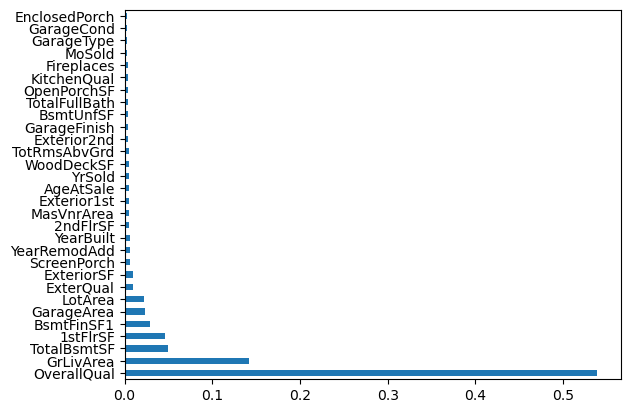

In [25]:
featureimportances = pd.Series(rf.feature_importances_, index = X_train.columns)
featureimportances.nlargest(30).plot(kind = 'barh')

In [26]:
featureimportances

GrLivArea          0.142009
MSSubClass         0.001605
MSZoning           0.001127
LotFrontage        0.002667
LotArea            0.022006
                     ...   
ExteriorSF         0.009025
AgeAtSale          0.004727
TotalFullBath      0.003698
TotalHalfBath      0.000522
GarageAgeAtSale    0.002000
Length: 83, dtype: float64

<AxesSubplot:ylabel='Frequency'>

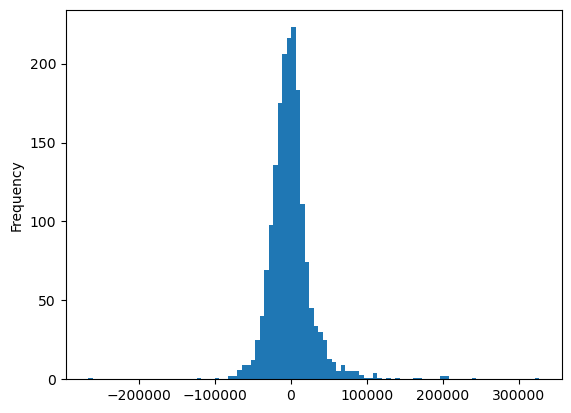

In [27]:
residuals = y_validate - rf.predict(X_validate)
residuals.plot.hist(bins=100)
#log axis
#skewness

In [28]:
np.mean(residuals**2)

881449443.433227

In [29]:
np.sqrt(np.mean(residuals**2))

29689.214260960613

We already have good R^2, but the feature importances suggest that this is primarily being driven by an indicator of overall quality of the house's material and finish and features tracking square footage. We will try to engineer the features to yield a model that has more insight into how fungible features impact sale price. Our overall approach will be to keep track of the features that we cannot change, but try to discretize them so that the model cannot simply encode the solution into (combinations of) continuous variables.

In [30]:
X_train.columns

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

### Feature Engineering

- Combine features and drop combined features to include in feature analysis.

#### Time since last remodel. 

In [31]:
housedf['TimeSinceLastWork'] = housedf['YrSold'] - housedf['YearRemodAdd']

#### Total SqFt

In [32]:
housedf['TotalSF'] = housedf['GrLivArea'] + housedf['TotalBsmtSF']
housedf['2Stories'] = housedf['2ndFlrSF'] > 0

#### Basement

- Fix me on iteration 2. Put all col names in one drop line.

In [33]:
housedf['FinBsmt'] = (housedf.TotalBsmtSF - housedf.BsmtUnfSF) > 0
housedf['UnfBsmt'] = housedf['BsmtUnfSF'] > 0

In [34]:
housedf.drop(['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF'], axis = 1, inplace = True)

#### Bathrooms

- (`Halfbaths` / 2) + `FullBaths` = `TotalFullBath`
     - Where `Halfbaths` = `BsmtHalfBath` + `HalfBath`

In [35]:
housedf['TotalBathrooms'] = ((housedf['BsmtHalfBath'] + housedf['HalfBath']) / 2) + housedf['BsmtFullBath'] + housedf['FullBath']

housedf.drop(['BsmtHalfBath', 'HalfBath', 'BsmtFullBath', 'FullBath', 'TotalFullBath', 'TotalHalfBath'], axis = 1, inplace = True)

#### Outdoor Living

- `WoodDeckSF` + `OpenPorchSF` + `EnclosedPorch` + `3SsnPorch` + `ScreenPorch` = `OutdoorLiving`
- Convert to boolean.

In [36]:
housedf['OutdoorLiving'] = housedf['WoodDeckSF'] + housedf['OpenPorchSF'] + housedf['EnclosedPorch'] + housedf['3SsnPorch'] + housedf['ScreenPorch']
housedf['OutdoorLiving'] = housedf['OutdoorLiving'] > 0

housedf.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis = 1, inplace = True)

#### Pool Area

- `HasPool` is the boolean value of `PoolArea`.

In [37]:
housedf_raw['PoolQC'].value_counts()

No pool    2570
TA            3
Ex            2
Gd            2
Fa            2
Name: PoolQC, dtype: int64

In [38]:
housedf['PoolQC'].value_counts()

3    2570
4       3
0       2
2       2
1       2
Name: PoolQC, dtype: int64

In [39]:
housedf_raw['PoolArea'].value_counts()

0      2570
144       1
800       1
519       1
444       1
648       1
228       1
561       1
576       1
368       1
Name: PoolArea, dtype: int64

In [40]:
housedf['PoolArea'].value_counts()

0      2570
144       1
800       1
519       1
444       1
648       1
228       1
561       1
576       1
368       1
Name: PoolArea, dtype: int64

In [41]:
housedf['HasPool'] = housedf['PoolArea'] > 0

housedf.drop(['PoolArea', 'PoolQC'], axis = 1, inplace = True)

#### Fireplaces

In [42]:
housedf['HasFireplace'] = housedf['Fireplaces'] > 0

housedf.drop(['FireplaceQu', 'Fireplaces'], axis = 1, inplace = True)

In [43]:
housedf.shape

(2579, 74)

In [44]:
housedf.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'ExteriorSF', 'AgeAtSale',
       'GarageAgeAtSale', 'TimeSinceLastWo

### 1.25. Random Feature Subset Analysis
Besides the saturated un-engineered model, in order to benchmark our feature selection process we will train and score models on random subsets of the features.

In [45]:
from sklearn.model_selection import train_test_split
X_trainvalidate, X_test, y_trainvalidate, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_trainvalidate, y_trainvalidate, test_size=0.875) # yields 70%/10%/20% split

In [46]:
import random
featurelist = X_train.columns.to_list()
rf = RandomForestRegressor()
subsetsize = 15

subsetscores = []

for _ in range(10):
    featuresubset = random.sample(featurelist, subsetsize)
    rf.fit(X_train[featuresubset], y_train)
    score = rf.score(X_validate[featuresubset], y_validate)
    subsetscores.append([featuresubset, score])

for featscore in subsetscores:
    print(featscore)

[['Condition1', 'YrSold', 'Alley', 'LandSlope', 'BsmtFinType1', 'BsmtFullBath', 'BsmtCond', 'YearBuilt', 'Electrical', 'GarageArea', 'GarageCond', 'MSSubClass', 'GarageFinish', '1stFlrSF', 'BsmtHalfBath'], 0.7489797313370761]
[['OverallQual', 'Condition1', 'BsmtHalfBath', '2ndFlrSF', '3SsnPorch', 'MoSold', 'BsmtFinType1', 'HalfBath', 'FireplaceQu', 'WoodDeckSF', 'LotArea', 'HouseStyle', 'BldgType', 'EnclosedPorch', 'Utilities'], 0.7742491358247169]
[['Functional', 'ScreenPorch', 'MoSold', 'BsmtFinType2', 'BsmtCond', 'OpenPorchSF', 'BsmtUnfSF', 'LandSlope', 'Exterior1st', 'Condition2', 'YrSold', 'WoodDeckSF', 'PoolArea', 'GarageType', 'LandContour'], 0.3697172942665493]
[['ExteriorSF', 'KitchenAbvGr', 'GarageCond', 'Heating', 'Utilities', 'LotArea', 'LowQualFinSF', 'BsmtFinType1', 'HouseStyle', 'RoofMatl', 'Electrical', 'ScreenPorch', 'HeatingQC', '3SsnPorch', 'MSSubClass'], 0.5137271157002854]
[['GarageCond', 'GarageCars', 'GarageFinish', 'MasVnrType', 'GarageArea', 'LotFrontage', 'Yea

### 1.3. Feature Analysis

**1.3.a.** Use the following methods for feature exploration and discovery of which are more important:

- `VarianceThreshold()`: Discover features with the least amount of variance with `VarianceThreshold()`. If the feature has low variance, this feature may not help us identify an increase in `SalePrice`.

- `KChooseBest`: Univariate feature selection with F test with `f_regression`. If the feature has a high F value and low p-value, that may be an indicator that feature will have a statistically significant effect on `y`.

- `SequentialFeatureSelector`: Forward selection of features to form a feature subset in a greedy fashion. The random forest estimmator is used to choose the best feature to add or remove based on the cross-validation score, R-Squared.

***Important*** Use `X_train` to do all analysis on feature selection.

In [47]:
y = housedf["SalePrice"]
X = housedf.drop("SalePrice", axis = 1)

In [48]:
from sklearn.model_selection import train_test_split
X_trainvalidate, X_test, y_trainvalidate, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_trainvalidate, y_trainvalidate, test_size=0.875) # yields 70%/10%/20% split

In [49]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

(257, 73)
(1806, 73)
(516, 73)


#### **1.3.b.** `VarianceThreshold()`

In [50]:
import sklearn.feature_selection as fs
varied_features = fs.VarianceThreshold(threshold = 0.25)
x_varied = varied_features.fit_transform(X_train)
x_varied.shape

(257, 58)

- `get_support` returns a boolean array.
    - If `True`, that feature has a variance greater than 0.25 indicating high variance and would be a meaningful predictor.  
    - If `False`, that feature has a variance less than 0.25 indicating low variance and would not be a meaningful predictor.

In [51]:
fs.VarianceThreshold.get_support(varied_features)

array([ True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False, False,
       False])

- Find the features that have low variance, values that have a variance less than 0.25 and returned `False` in the above boolean array.

In [52]:
concol = [column for column in X_train.columns 
          if column not in X_train.columns[varied_features.get_support()]]

for features in concol:
    print(features)

Street
Alley
Utilities
LandSlope
Condition2
Heating
CentralAir
KitchenAbvGr
MiscFeature
2Stories
FinBsmt
UnfBsmt
OutdoorLiving
HasPool
HasFireplace


In [53]:
housedf['2Stories'].value_counts()

False    1464
True     1115
Name: 2Stories, dtype: int64

#### Observations from feature `VarianceThreshold` analysis:

The following features have low variance and may not have a distinguishable effect on `SalePrice`:

- Features Regarding Location:
    - `Street`, `Latitude`, `Longitude`, `Condition2`
- Features Regarding Lot:
    - `Alley`, `LandSlope`
- Features Regarding Utilities:
    - `Utilities`, `Heating`, `CentralAir`
- Features Regarding Bathrooms:
    - `BsmtHalfBath`, `Halfbath`
- Features Regarding Misc:
    - `KitchAbvGr`, `MiscFeature`
    
This indicates we may want to drop these features or combine them with another feature. 

#### **1.3.c.** `f_regression`

   - Univariate feature selection with F test with `f_regression`. If the feature has a high F value and low p-value, that may be an indicator that feature will have a statistically significant effect on `y`.

   - Use `k` equal to `all` to select all features instead of top `k` features that score best for exploratory purposes.

In [54]:
skb = fs.SelectKBest(score_func = fs.f_regression, k = 'all')

In [55]:
best_feats = skb.fit_transform(X_train, y_train)

In [56]:
p_vals = skb.pvalues_

- Print all `pvalues_` to explore which features are significant (< 0.05) and which are not (> 0.05).

In [57]:
for i in range(len(skb.pvalues_)):
 print('%s: %f' % (X_train.columns[i], skb.pvalues_[i]))

GrLivArea: 0.000000
MSSubClass: 0.138125
MSZoning: 0.000341
LotFrontage: 0.000158
LotArea: 0.000000
Street: 0.748781
Alley: 0.027110
LotShape: 0.000000
LandContour: 0.115196
Utilities: 1.000000
LotConfig: 0.051712
LandSlope: 0.382919
Neighborhood: 0.010646
Condition1: 0.056297
Condition2: 0.262134
BldgType: 0.220700
HouseStyle: 0.028510
OverallQual: 0.000000
OverallCond: 0.319056
YearBuilt: 0.000000
YearRemodAdd: 0.000000
RoofStyle: 0.000908
RoofMatl: 0.000000
Exterior1st: 0.134413
Exterior2nd: 0.087878
MasVnrType: 0.028015
MasVnrArea: 0.000000
ExterQual: 0.000000
ExterCond: 0.707115
Foundation: 0.000000
BsmtQual: 0.000000
BsmtCond: 0.379668
BsmtExposure: 0.000000
BsmtFinType1: 0.013334
BsmtFinType2: 0.726203
Heating: 0.036232
HeatingQC: 0.000000
CentralAir: 0.000114
Electrical: 0.000683
1stFlrSF: 0.000000
2ndFlrSF: 0.000000
LowQualFinSF: 0.210377
BedroomAbvGr: 0.002069
KitchenAbvGr: 0.099581
KitchenQual: 0.000000
TotRmsAbvGrd: 0.000000
Functional: 0.080342
GarageType: 0.000000
GarageF

#### Observations from `f_regression` p-values.

The following features have a `p-value_` of 0.05 or higher, so these will not have a significant effect on prediciting `SalePrice`:

- `LandContour`: 0.446418
- `Utilities`: 0.088177
- `Condition2`: 0.202088
- `MiscVal`: 0.323951
- `MoSold`: 0.640976
- `YrSold`: 0.818901
- `SaleType`: 0.792826

- Now use `SelectKBest` using `k = 10` to select the top 10 features that have the highest F-score and lowest p-values.

In [58]:
skb = fs.SelectKBest(score_func = fs.f_regression, k = 10)

In [59]:
best_feats = skb.fit_transform(X_train, y_train)

In [60]:
concol = [column for column in X.columns 
          if column in X.columns[skb.get_support()]]

for features in concol:
    print(features)

GrLivArea
OverallQual
MasVnrArea
BsmtQual
1stFlrSF
KitchenQual
GarageCars
GarageArea
TotalSF
TotalBathrooms


#### **1.3.c.** `SequentialFeatureSelector`

In [61]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor

In [62]:
rf = RandomForestRegressor()

In [63]:
sfs = SequentialFeatureSelector(estimator = rf, n_features_to_select = 'auto', tol=0.005, 
                                direction = 'backward', scoring = "r2", cv = 5)

In [64]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=RandomForestRegressor(),
                          n_features_to_select='auto', scoring='r2', tol=0.005)

In [65]:
sfs.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [66]:
rf.fit(sfs.transform(X_train), y_train).score(sfs.transform(X_validate), y_validate)

0.8579842370725228

In [67]:
sfs.transform(X_train).shape

(257, 72)

In [68]:
selected_feat = X_train.columns[(sfs.get_support())]
print(selected_feat)

Index(['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'ExteriorSF', 'AgeAtSale', 'GarageAgeAtSale', 'TimeSinceLastWork',
       'TotalSF', '2Stories

In [69]:
housedf.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'ExteriorSF', 'AgeAtSale',
       'GarageAgeAtSale', 'TimeSinceLastWo

### Feature Analysis Summary

#### Feature Exclusion

`VarianceThreshold()` Features that has *LOW* variance (ones we should exclude or combine):

- `Street`
- `Alley`
- `Utilities`
- `LandSlope`
- `Condition2`
- `RoofMatl`
- `Heating`
- `CentralAir`
- `KitchenAbvGr`
- `MiscFeature`
- `2Stories`
- `FinBsmt`
- `UnfBsmt`
- `OutdoorLiving`
- `HasPool`
- `HasFireplace`

`f_regression` Features that have a *HIGH* p-value (ones we should exclude or combine):

- `LandContour`: 0.446418
- `Utilities`: 0.088177
- `Condition2`: 0.202088
- `MiscVal`: 0.323951
- `MoSold`: 0.640976
- `YrSold`: 0.818901
- `SaleType`: 0.79282

Features that both `VarianceThreshold()` and `f_regression` methods told us to exclude:

- `Utitities`
- `Condition2`

#### Feature Inclusion

Since `VarianceThreshold()` has multiple features with high variance that are too numerous to list, we will jump into which features `SelectKBest` with `f_regression` told us we should include.

`f_regression` Top 10 Features:

- `GrLivArea`
- `OverallQual`
- `ExterQual`
- `BsmtQual`
- `TotalBsmtSF`
- `1stFlrSF`
- `KitchenQual`
- `GarageCars`
- `GarageArea`
- `TotalFullBath`

`SequentialFeatureSelection` Features:

- `Neighborhood` 
- `OverallQual`
- `OverallCond` 
- `YearBuilt`
- `BsmtFinType1`
- `1stFlrSF`
- `GarageCars`
- `ExteriorSF`
- `TotalSF`
- `TotalFullBath`

Features both methods had in common to include:

- `OverallQual`
- `1stFlrSF`
- `GarageCars`
- `TotalFullBath`

# Feature Reduction

In [70]:
housedf.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'ExteriorSF', 'AgeAtSale',
       'GarageAgeAtSale', 'TimeSinceLastWo

In [71]:
housedf.shape

(2579, 74)

In [72]:
housedf_reduced = housedf.copy()

In [73]:
housedf_reduced.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'ExteriorSF', 'AgeAtSale',
       'GarageAgeAtSale', 'TimeSinceLastWo

In [74]:
housedf_reduced.shape

(2579, 74)

### Justification of Dropping Features

- `Street`: Showed as low variance. Neighborhood should capture this data.
- `Alley`: Showed as low varaince. Neighorhood should capture this inforamtion. 
- `LandContour`: This had a p-value > 0.05. Keep LotShape.
- `Utitilies`: P-value > 0.05 and low variance. 
- `LandSlope`: Low variance.
- `Condition2`: Low variance.
- `Exterior2nd`: Exterior1st should capture enough of this information.
- `MasVnrType`: Exterior1st should capture enough of this information with MasVnrArea which has a higher F-score.
- `BsmtQual`: Height of the basement ceiling doesn't look significant to SalePrice after EDA.
- `BsmtFinType1`: Quality of basement captured unfinished as a category and we aleady have that in a feature.
- `BsmtFinType2`: Quality of basement captured with combination of feautres.
- `Heating`: Showing low variance as well as low F score.
- `CentralAir`: Most houses have central A/C.
- `1stFlrSF`: This is captured in `GrLivArea`.
- `2ndFlrSF`: This is captured in `GrLivArea`.
- `LowQualFinSF`: Showed a high p-value indicating not significant to the model.
- `TotRmsAbvGrd`: Bedrooms is the more common listed on a house listing.
- `Functional`: Is not listed on a common house listing and is subjective.
- `FireplaceQu`: Number of fireplaces is sufficient.
- `GarageArea`: `GarageCars` is sufficient.
- `MiscFeature`: Showed low feature importance and is not known what this feature is to be changed by a flipper.
- `MoSold`: Showed low feature importance.
- `YrSold`: Showed low feature importance.
- `SaleType`: Showed low feature importance.
- `SaleCondition`: Showed low feature importance.
- `RoofMatl`: Showed low variance.
- `KitchenAbvGr`: Showed low variance. 
- `Latitude`: Showed low variance (likely due to imputing missing values with mode).
- `Longitude`: Showed low variance (likely due to imputing missing values with mode).

In [75]:
housedf_reduced.drop(['Street'], axis = 1, inplace = True)
housedf_reduced.drop(['Alley'], axis = 1, inplace = True)
housedf_reduced.drop(['LandContour'], axis = 1, inplace = True)
housedf_reduced.drop(['Utilities'], axis = 1, inplace = True)
housedf_reduced.drop(['LandSlope'], axis = 1, inplace = True)
housedf_reduced.drop(['Condition2'], axis = 1, inplace = True)
housedf_reduced.drop(['Exterior2nd'], axis = 1, inplace = True)
housedf_reduced.drop(['MasVnrType'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtQual'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtFinType1'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtFinType2'], axis = 1, inplace = True)
housedf_reduced.drop(['Heating'], axis = 1, inplace = True)
housedf_reduced.drop(['CentralAir'], axis = 1, inplace = True)
housedf_reduced.drop(['1stFlrSF'], axis = 1, inplace = True)
housedf_reduced.drop(['2ndFlrSF'], axis = 1, inplace = True)
housedf_reduced.drop(['LowQualFinSF'], axis = 1, inplace = True)
housedf_reduced.drop(['TotRmsAbvGrd'], axis = 1, inplace = True)
housedf_reduced.drop(['Functional'], axis = 1, inplace = True)
housedf_reduced.drop(['FireplaceQu'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageArea'], axis = 1, inplace = True)
housedf_reduced.drop(['MiscFeature'], axis = 1, inplace = True)
housedf_reduced.drop(['MiscVal'], axis = 1, inplace = True)
housedf_reduced.drop(['MoSold'], axis = 1, inplace = True)
housedf_reduced.drop(['YrSold'], axis = 1, inplace = True)
housedf_reduced.drop(['SaleType'], axis = 1, inplace = True)
housedf_reduced.drop(['SaleCondition'], axis = 1, inplace = True)
housedf_reduced.drop(['RoofMatl'], axis = 1, inplace = True)
housedf_reduced.drop(['KitchenAbvGr'], axis = 1, inplace = True)
housedf_reduced.drop(['PoolQC'], axis = 1, inplace = True)
housedf_reduced.drop(['Latitude'], axis = 1, inplace = True)
housedf_reduced.drop(['Longitude'], axis = 1, inplace = True)

KeyError: "['FireplaceQu'] not found in axis"

In [ ]:
housedf_reduced.drop(['MSSubClass'], axis = 1, inplace = True)
housedf_reduced.drop(['MSZoning'], axis = 1, inplace = True)
housedf_reduced.drop(['LotFrontage'], axis = 1, inplace = True)
housedf_reduced.drop(['LotArea'], axis = 1, inplace = True)
housedf_reduced.drop(['LotShape'], axis = 1, inplace = True)
housedf_reduced.drop(['LotConfig'], axis = 1, inplace = True)


housedf_reduced.drop(['Condition1'], axis = 1, inplace = True)
housedf_reduced.drop(['BldgType'], axis = 1, inplace = True)
housedf_reduced.drop(['HouseStyle'], axis = 1, inplace = True)
housedf_reduced.drop(['OverallCond'], axis = 1, inplace = True)
housedf_reduced.drop(['RoofStyle'], axis = 1, inplace = True)
housedf_reduced.drop(['Exterior1st'], axis = 1, inplace = True)


housedf_reduced.drop(['MasVnrArea'], axis = 1, inplace = True)
housedf_reduced.drop(['ExterQual'], axis = 1, inplace = True)
housedf_reduced.drop(['ExterCond'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtCond'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtExposure'], axis = 1, inplace = True)
housedf_reduced.drop(['BsmtUnfSF'], axis = 1, inplace = True)


housedf_reduced.drop(['HeatingQC'], axis = 1, inplace = True)
housedf_reduced.drop(['Electrical'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageType'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageFinish'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageQual'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageCond'], axis = 1, inplace = True)


housedf_reduced.drop(['PavedDrive'], axis = 1, inplace = True)
housedf_reduced.drop(['Fence'], axis = 1, inplace = True)
housedf_reduced.drop(['ExteriorSF'], axis = 1, inplace = True)
housedf_reduced.drop(['AgeAtSale'], axis = 1, inplace = True)
housedf_reduced.drop(['GarageAgeAtSale'], axis = 1, inplace = True)

# Modeling

Define X and y with `housedf_reduced` and split the data for hyperparameter tuning.

In [76]:
y = housedf["SalePrice"]
X = housedf.drop("SalePrice", axis = 1)

In [77]:
from sklearn.model_selection import train_test_split
X_trainvalidate, X_test, y_trainvalidate, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X_trainvalidate, y_trainvalidate, test_size=0.875) # yields 70%/10%/20% split

#### Randomized Hyperparameter Grid to find a range of values.

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [79]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [80]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [81]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [82]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [83]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [84]:
rf_random.score(X_validate, y_validate)

0.8042643642847381

<AxesSubplot:>

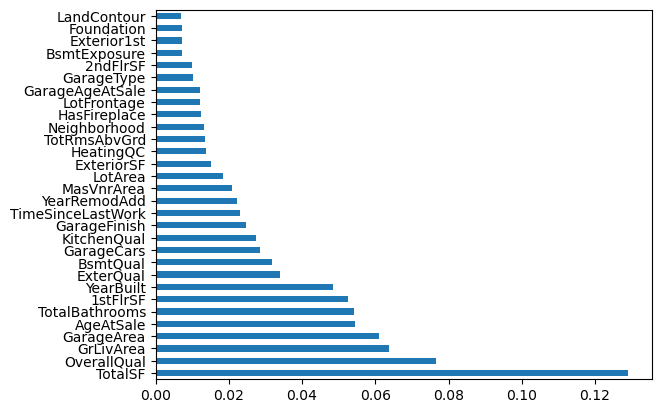

In [85]:
featureimportances = pd.Series(rf_random.best_estimator_.feature_importances_, index = X_train.columns)
featureimportances.nlargest(30).plot(kind = 'barh')

### Visualize model performance with only most important features

In [86]:
# sort by most to least important
featureimportances = featureimportances.sort_values(ascending=False)

In [87]:
# train rf model adding one feature at a time from most to least important
step_scores = []
for i in range(len(featureimportances)):
    X_trainvalidate_sub = X_trainvalidate[featureimportances.index[0:i+1]]
    X_test_sub = X_test[featureimportances.index[0:i+1]]
    rf.fit(X_trainvalidate_sub, y_trainvalidate)
    score = rf.score(X_test_sub, y_test)
    step_scores.append(score)

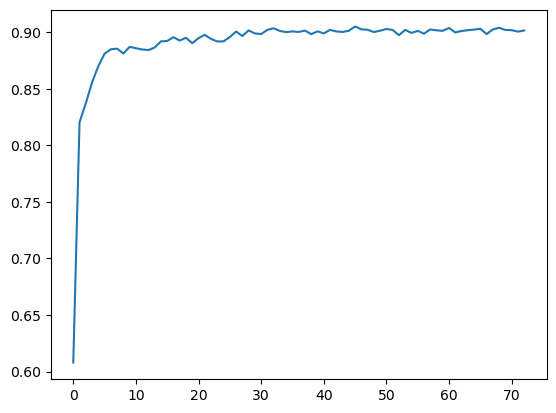

In [88]:
import matplotlib.pyplot as plt
plt.plot(step_scores)

#### Performance starts to level off at about 0.91

In [89]:
print(pd.Series(step_scores, index=featureimportances.index).to_string())

TotalSF              0.608007
OverallQual          0.820400
GrLivArea            0.837128
GarageArea           0.855546
AgeAtSale            0.869966
TotalBathrooms       0.881024
1stFlrSF             0.884850
YearBuilt            0.885446
ExterQual            0.881143
BsmtQual             0.887027
GarageCars           0.885803
KitchenQual          0.884723
GarageFinish         0.884165
TimeSinceLastWork    0.886453
YearRemodAdd         0.891843
MasVnrArea           0.892202
LotArea              0.895544
ExteriorSF           0.892577
HeatingQC            0.895050
TotRmsAbvGrd         0.890262
Neighborhood         0.894702
HasFireplace         0.897653
LotFrontage          0.894027
GarageAgeAtSale      0.891793
GarageType           0.891858
2ndFlrSF             0.895729
BsmtExposure         0.900583
Exterior1st          0.896594
Foundation           0.901546
LandContour          0.898891
Exterior2nd          0.898303
OverallCond          0.902046
BedroomAbvGr         0.903448
BsmtFinTyp

### Build RF model with the 13 most important features and CV for hyperparameters

In [90]:
X_trainvalidate_sub = X_trainvalidate[featureimportances.index[0:13]]
X_test_sub = X_test[featureimportances.index[0:13]]

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_trainvalidate_sub, y_trainvalidate)
rf_random.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [91]:
rf_random.score(X_test_sub, y_test)

0.8935048188127539

<AxesSubplot:>

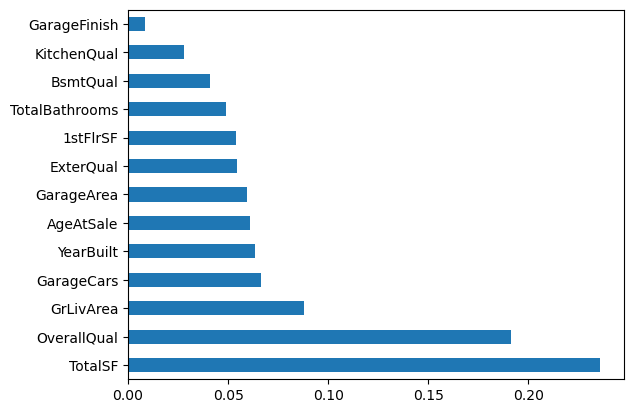

In [92]:
featureimportances = pd.Series(rf_random.best_estimator_.feature_importances_,
                               index = X_trainvalidate_sub.columns)
featureimportances.nlargest(30).plot(kind = 'barh')

In [156]:
base_model = RandomForestRegressor()
base_model.fit(X_trainvalidate, y_trainvalidate)
base_model.score(X_test, y_test)

0.8986752883330037

### Feature Importance | Shapley Values

Find out how positive or negative features contribute to the prediction of `SalesPrice` using Shapley Values. Reference:
https://github.com/slundberg/shap


In [98]:
import shap

In [118]:
explainer = shap.Explainer(rf_random.predict, X_test_sub)

In [119]:
shap_values = explainer(X_test_sub)

Permutation explainer: 517it [27:30,  3.22s/it]                                 


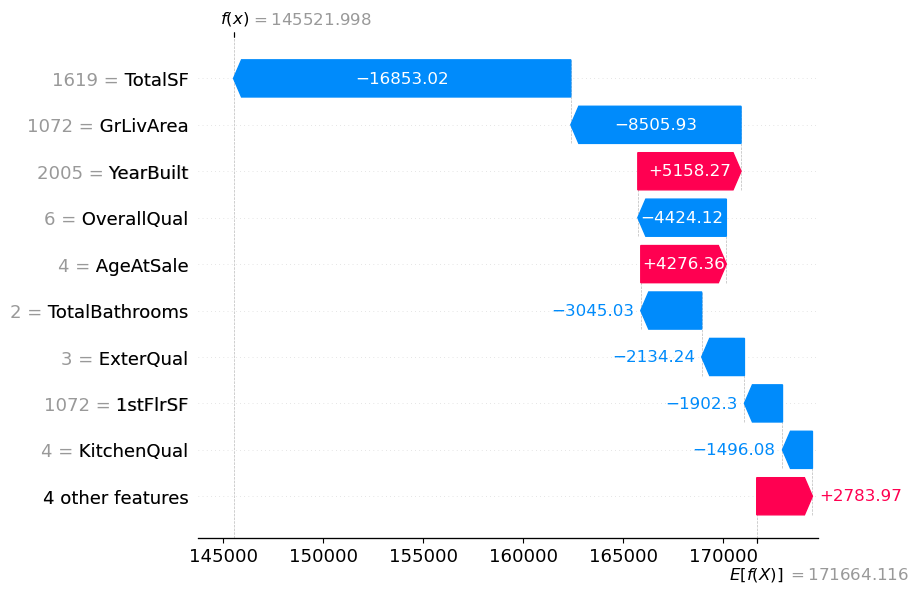

In [121]:
shap.plots.waterfall(shap_values[0])

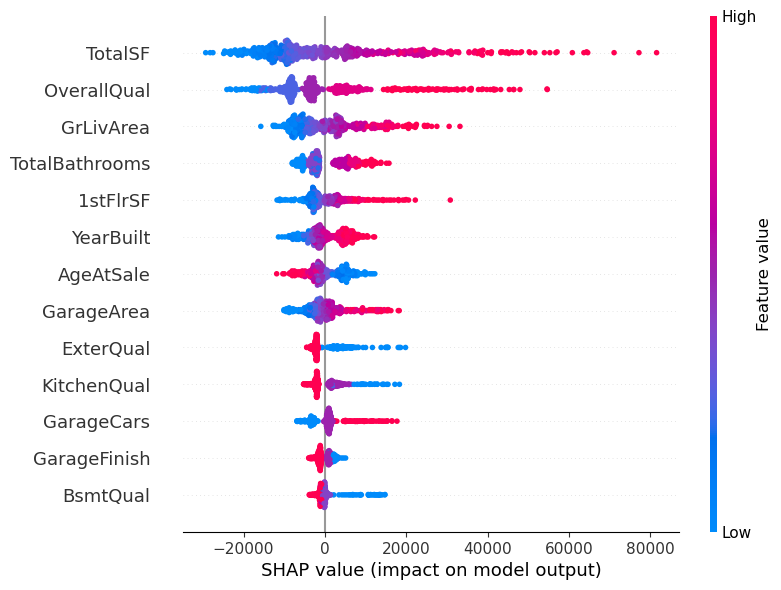

In [147]:
shap.plots.beeswarm(shap_values, max_display=13)

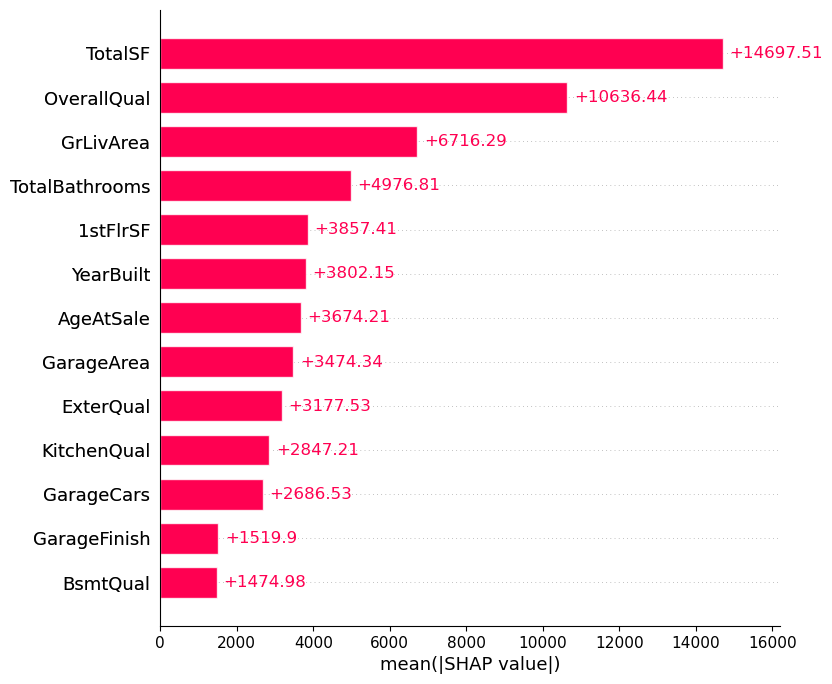

In [157]:
shap.plots.bar(shap_values, max_display=13)

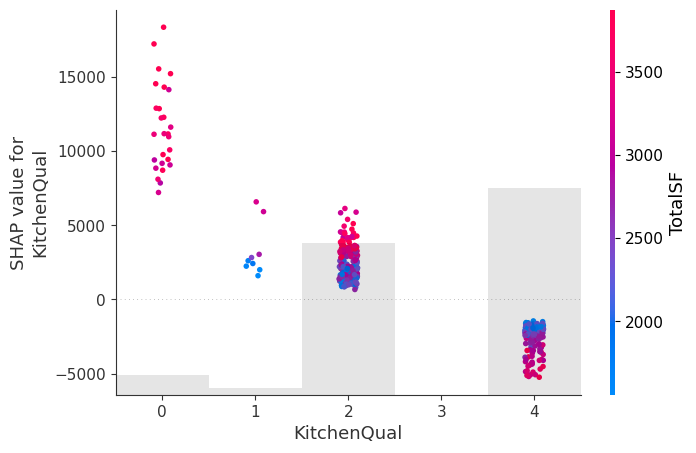

In [138]:
shap.plots.scatter(shap_values[:,"KitchenQual"], color=shap_values[:,"TotalSF"])

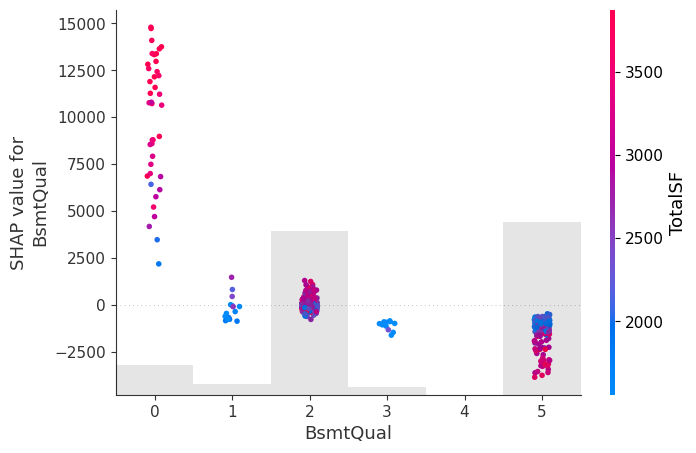

In [143]:
shap.plots.scatter(shap_values[:,"BsmtQual"], color=shap_values[:,"TotalSF"])

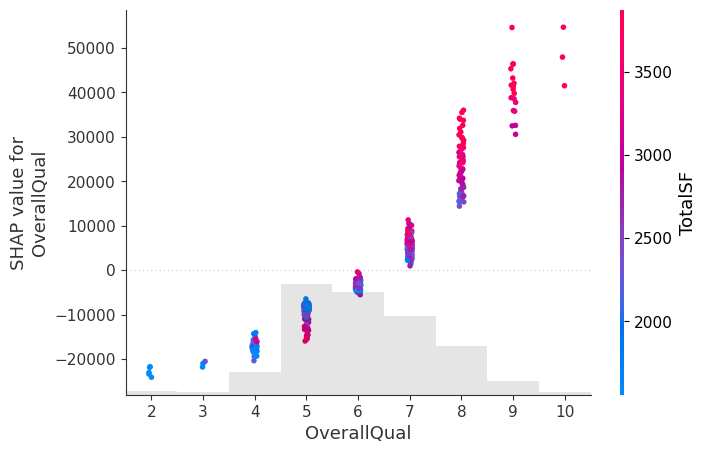

In [148]:
shap.plots.scatter(shap_values[:,"OverallQual"], color=shap_values[:,"TotalSF"])

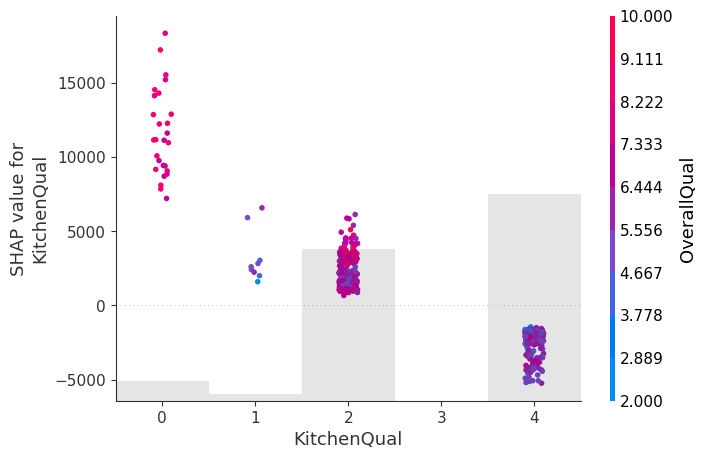

In [139]:
shap.plots.scatter(shap_values[:,"KitchenQual"], color=shap_values[:,"OverallQual"])

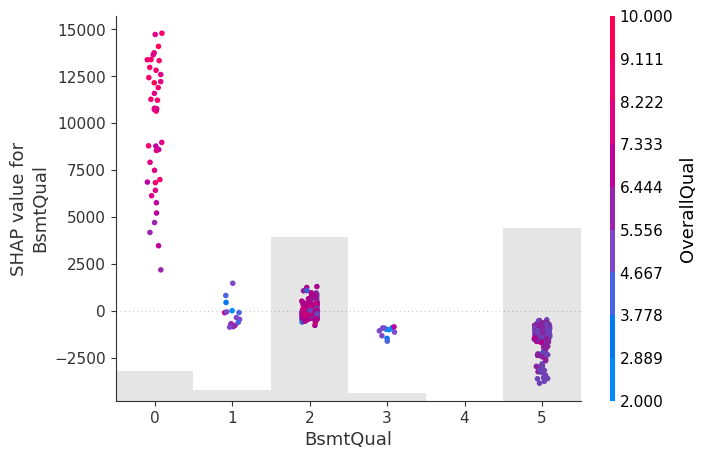

In [144]:
shap.plots.scatter(shap_values[:,"BsmtQual"], color=shap_values[:,"OverallQual"])

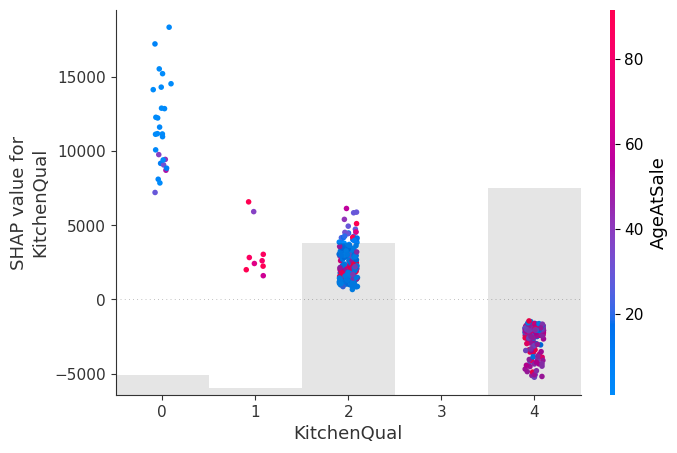

In [140]:
shap.plots.scatter(shap_values[:,"KitchenQual"], color=shap_values[:,"AgeAtSale"])

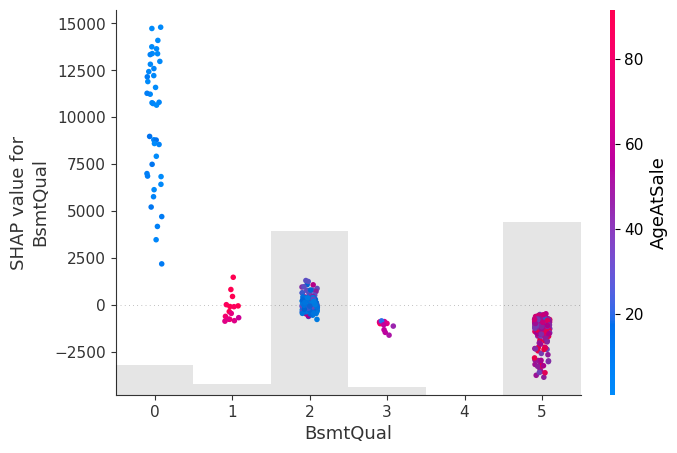

In [145]:
shap.plots.scatter(shap_values[:,"BsmtQual"], color=shap_values[:,"AgeAtSale"])

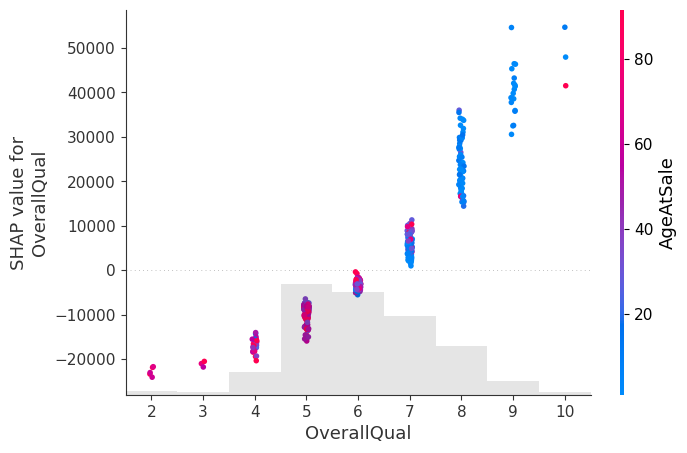

In [149]:
shap.plots.scatter(shap_values[:,"OverallQual"], color=shap_values[:,"AgeAtSale"])

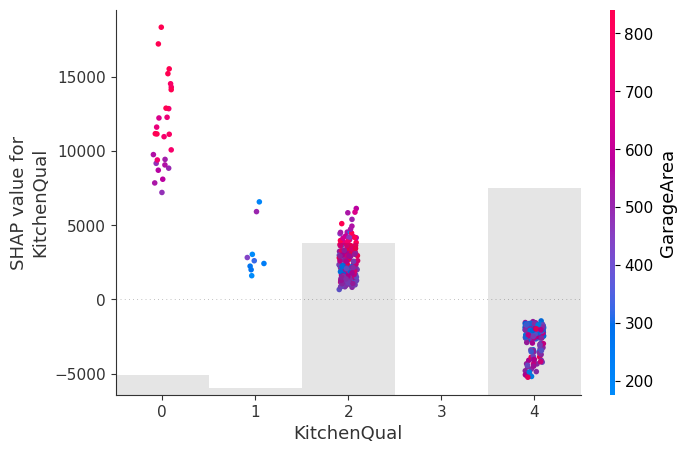

In [142]:
shap.plots.scatter(shap_values[:,"KitchenQual"], color=shap_values[:,"GarageArea"])

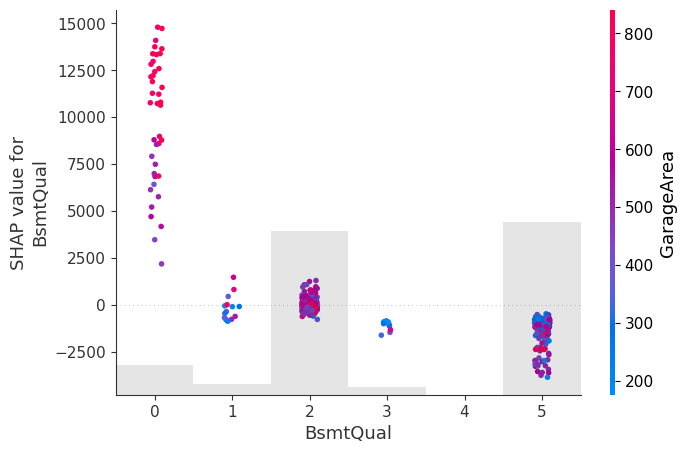

In [146]:
shap.plots.scatter(shap_values[:,"BsmtQual"], color=shap_values[:,"GarageArea"])

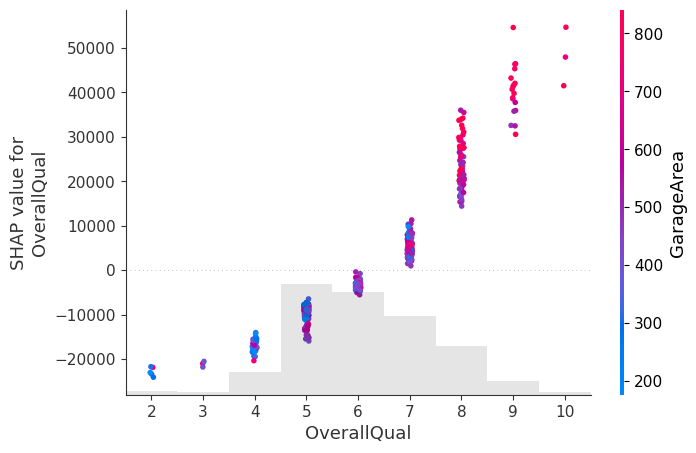

In [150]:
shap.plots.scatter(shap_values[:,"OverallQual"], color=shap_values[:,"GarageArea"])

- - - 

# Scratch Pad

- I've included this in my notebook to document the initial feature exploration, but was not used in final modeling. 

#### Iteration 1 Features

In [ ]:
X = housedf_reduced.drop("SalePrice", axis = 1)
y = housedf_reduced["SalePrice"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
score = rf.score(X_train, y_train)
print("R-squared:", score)

In [ ]:
ypred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

#### Iteration 2 Features
#### From the `f_regression` method. Keep all features that had p-values less than 0.05.

##### Observations from `f_regression` p-values.

The following features have a p-value of 0.05 or higher, so these will not be significant on prediciting `SalePrice`:

- `LandContour`: 0.051559
- `Utilities`: 0.083717
- `BsmtFinSF2`: 0.249295
- `LowQualFinSF`: 0.117548
- `BsmtHalfBath`: 0.086452
- `3SsnPorch`: 0.112386
- `PoolArea`: 0.117289
- `MiscVal`: 0.338131
- `MoSold`: 0.518331
- `YrSold`: 0.948975
- `SaleType`: 0.962618

In [ ]:
housedf_iter2 = housedfcopy.copy()

In [ ]:
housedf_iter2.shape

In [ ]:
housedf_iter2.columns

In [ ]:
housedf_iter2.drop(['LandContour'], axis = 1, inplace = True)

housedf_iter2.drop(['Utilities'], axis = 1, inplace = True)

housedf_iter2.drop(['BsmtFinSF2'], axis = 1, inplace = True)

housedf_iter2.drop(['LowQualFinSF'], axis = 1, inplace = True)

housedf_iter2.drop(['BsmtHalfBath'], axis = 1, inplace = True)

housedf_iter2.drop(['3SsnPorch'], axis = 1, inplace = True)

housedf_iter2.drop(['PoolArea'], axis = 1, inplace = True)

housedf_iter2.drop(['MiscVal'], axis = 1, inplace = True)

housedf_iter2.drop(['MoSold'], axis = 1, inplace = True)

housedf_iter2.drop(['YrSold'], axis = 1, inplace = True)

housedf_iter2.drop(['SaleType'], axis = 1, inplace = True)

In [ ]:
X = housedf_iter2.drop("SalePrice", axis = 1)
y = housedf_iter2["SalePrice"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
score = rf.score(X_train, y_train)
print("R-squared:", score)

In [ ]:
ypred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

#### Iteration 3

#### Raw Dataset Top 10 Features.
- GrLivArea
- OverallQual
- ExterQual
- BsmtQual
- TotalBsmtSF
- 1stFlrSF
- KitchenQual
- GarageCars
- GarageArea
- TotalFullBath


#### Feature Engineered Dataset Top 10 Features.
- GrLivArea
- OverallQual
- YearBuilt
- YearRemodAdd
- ExterQual
- TotalBsmtSF
- KitchenQual
- GarageFinish
- GarageCars
- TotalBathrooms

In [ ]:
housedf_iter3 = housedf_reduced[['SalePrice', 'GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'TotalBsmtSF', 'KitchenQual', 'GarageFinish', 'GarageCars', 'TotalBathrooms']]

In [ ]:
X = housedf_iter3.drop("SalePrice", axis = 1)
y = housedf_iter3["SalePrice"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
score = rf.score(X_train, y_train)
print("R-squared:", score)

In [ ]:
ypred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()